# Data Science Essentials: GeoPandas
    Lee Woodside
    MATH 403
    09.27.2021

In [156]:
! pip install geopandas
from google.colab import files
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from matplotlib import animation
from datetime import datetime
from IPython.display import HTML
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
%matplotlib inline

## Problem 1

Read in the file *airports.csv* as a pandas dataframe.
Create three convex hulls around the three sets of airports listed below.
This can be done by passing in lists of the airports' coordinates to a *shapely.geometry.Polygon* object.

1. Maio Airport, Scatsta Airport, Stokmarknes Skagen Airport, Bekily Airport, K. D. Matanzima Airport, RAF Ascension Island
2. Oiapoque Airport, Maio Airport, Zhezkazgan Airport, Walton Airport, RAF Ascension Island, Usiminas Airport, Piloto Osvaldo Marques Dias Airport
3. Zhezkazgan Airport, Khanty Mansiysk Airport, Novy Urengoy Airport, Kalay Airport, Biju Patnaik Airport, Walton Airport
	
Create a new GeoDataFrame with these three Polygons as entries.
Plot this GeoDataFrame on top of an outlined world map.

In [134]:
# upload airport.csv
airport = files.upload()

Text(0.5, 1.0, 'World Airports')

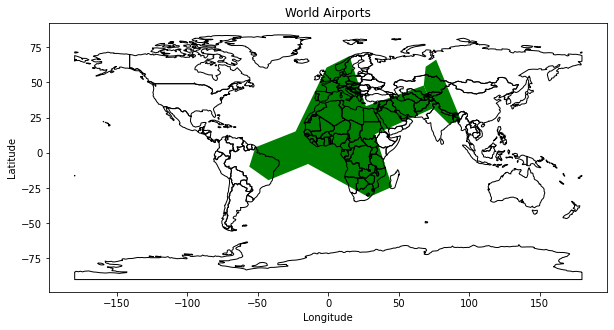

In [135]:
first_set = ['Maio Airport', 'Scatsta Airport', 'Stokmarknes Skagen Airport',
                 'Bekily Airport','K. D. Matanzima Airport', 'RAF Ascension Island']
second_set = ['Oiapoque Airport','Maio Airport', 'Zhezkazgan Airport',
                'Walton Airport','RAF Ascension Island','Usiminas Airport',
                 'Piloto Osvaldo Marques Dias Airport']
third_set = ['Zhezkazgan Airport','Khanty Mansiysk Airport','Novy Urengoy Airport',
                 'Kalay Airport','Biju Patnaik Airport','Walton Airport']

# Set outline of world countries as base
fig,ax = plt.subplots(figsize=(10,7), ncols=1, nrows=1)
base = world.boundary.plot(edgecolor='black', ax=ax, linewidth=1)
# Load airport data and convert to a GeoDataFrame
airports = pd.read_csv('airports.csv', index_col="Name")
airports['Coordinates'] = list(zip(airports.Longitude, airports.Latitude))

airports['Coordinates'] = airports.Coordinates.apply(Point)
airports = gpd.GeoDataFrame(airports, geometry='Coordinates')
first_set_airports = gpd.GeoDataFrame(airports.loc[first_set], geometry='Coordinates')
second_set_airports = gpd.GeoDataFrame(airports.loc[second_set], geometry='Coordinates')
third_set_airports = gpd.GeoDataFrame(airports.loc[third_set], geometry='Coordinates')


first_set_poly =  Polygon(list(first_set_airports.Coordinates))
second_set_poly = Polygon(list(second_set_airports.Coordinates))
third_set_poly = Polygon(list(third_set_airports.Coordinates))

polys = gpd.GeoDataFrame([first_set_poly, second_set_poly, third_set_poly], geometry=0)

# Plot airports on top of world map
polys.plot(ax=base, marker='o', color='green', markersize=1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('World Airports')





## Problem 2
Use the command *geopandas.read_file('county_data.gpkg')* to create a GeoDataFrame of information about US counties.
Each county's shape is stored in the *geometry* column.
Use this to **plot the outlines of all US counties two times**, first using the default CRS and then using EPSG:5071.

Next, create a new GeoDataFrame that combines all counties within a single state.
Drop states with the following STATEFP codes: 02, 15, 60, 66, 69, 72, 78.
Plot this GeoDataFrame to see an outline of the 48 contiguous states.
Ensure a CRS of 5071.

In [136]:
# upload county.gpkg.zip
# county = files.upload()
# !unzip county_data.gpkg.zip
county_df = gpd.read_file('county_data.gpkg')
county_df_5071 = gpd.read_file('county_data.gpkg')

Text(0.5, 1.0, 'US Counties')

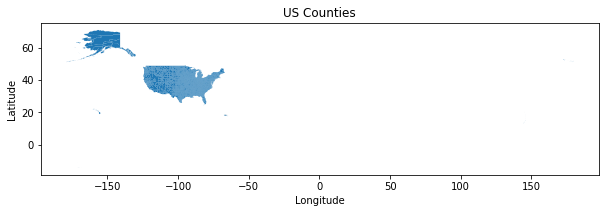

In [137]:
fig1,ax1 = plt.subplots(figsize=(10,10), ncols=1, nrows=1)

county_df.plot(ax=ax1)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('US Counties')

Text(0.5, 1.0, 'US Counties EPSG:5071')

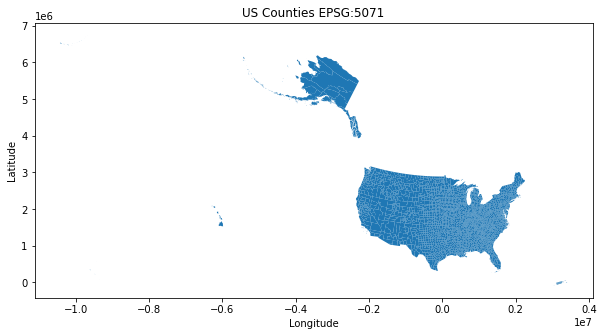

In [138]:
fig2,ax2 = plt.subplots(figsize=(10,7), ncols=1, nrows=1)

county_df_5071.to_crs(5071, inplace=True)
county_df_5071.plot(ax=ax2)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('US Counties EPSG:5071')

Text(0.5, 1.0, 'Dissolve')

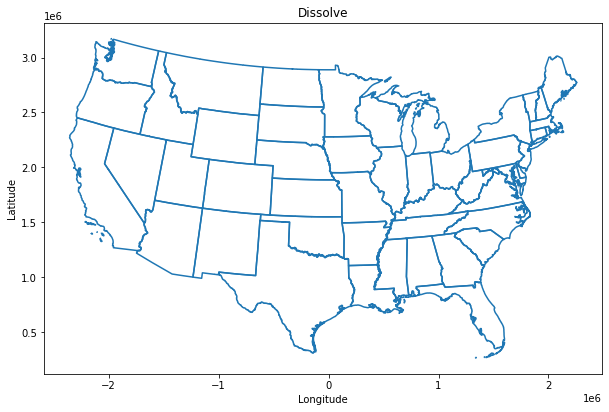

In [139]:
delete_rows = county_df_5071[county_df_5071['STATEFP'].isin(['02', '15', '60', '66', '69', '72', '78'])].index 
# delete_rows
county_df_5071.drop(delete_rows, inplace=True)

county_dissolve = county_df_5071.dissolve(by = 'STATEFP')

fig3,ax3 = plt.subplots(figsize=(10,7), ncols=1, nrows=1)

county_dissolve.boundary.plot(ax=ax3)
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.set_title('Dissolve')

## Problem 3

Load in the file *nytimes.csv* as a DataFrame.
This file includes county-level data for the cumulative cases and deaths of Covid-19 in the US, starting with the first case in Snohomish County, Washington, on January 21, 2020.
**First, convert the *date* column into a *DatetimeIndex*.**

Next, use county FIPS codes to **merge your GeoDataFrame from the previous problem with the DataFrame you just created.**
A FIPS code is a 5-digit unique identifier for geographic locations.
For this lab, we will ignore rows in the Covid-19 DataFramw tih unknown FIPS codes.
Also, we will just be examining data from the contiguous US, so **drop all data from Hawaii and Alaska.**

Note that the *fips* column of the Covid-19 DataFrame stores entries as floats, but the county GeoDataFrame stores FIPS codes as strings, with the first two digits in the *STATEFP* column and the last three in the *COUNTYFP* column.

**Plot the cases from March 21, 2020 on top of your state outline map from the previous problem.
Finally, print out the name of the county with the most cases along with its case count.**

In [140]:
# ny_times = files.upload()
cov_19_df = pd.read_csv('nytimes.csv')
delete_rows1 = cov_19_df[cov_19_df['state'].isin(['Hawaii', 'Alaska'])].index
cov_19_df.drop(delete_rows1)

Unnamed: 0        date      county       state     fips  cases  deaths
0                0  2020-01-21   Snohomish  Washington  53061.0      1       0
1                1  2020-01-22   Snohomish  Washington  53061.0      1       0
2                2  2020-01-23   Snohomish  Washington  53061.0      1       0
3                3  2020-01-24        Cook    Illinois  17031.0      1       0
4                4  2020-01-24   Snohomish  Washington  53061.0      1       0
...            ...         ...         ...         ...      ...    ...     ...
258022      258022  2020-06-21  Sweetwater     Wyoming  56037.0     53       0
258023      258023  2020-06-21       Teton     Wyoming  56039.0    110       1
258024      258024  2020-06-21       Uinta     Wyoming  56041.0    138       0
258025      258025  2020-06-21    Washakie     Wyoming  56043.0     38       5
258026      258026  2020-06-21      Weston     Wyoming  56045.0      1       0

[256190 rows x 7 columns]

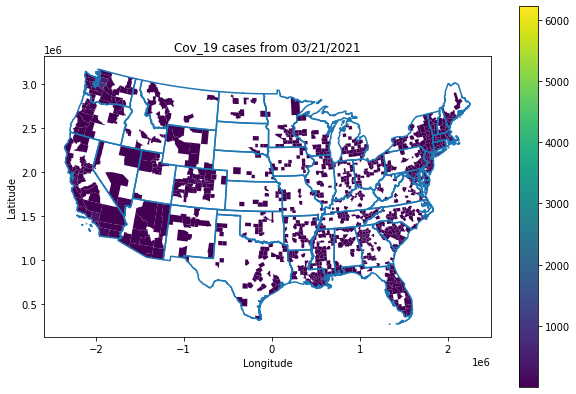

In [142]:
cov_19_df["date"] = pd.to_datetime(cov_19_df["date"])

county_df_5071['fips'] = county_df_5071.STATEFP + county_df_5071.COUNTYFP
county_df_5071['fips'] = county_df_5071['fips'].apply(int)

cov_merge = county_df_5071.merge(cov_19_df, on='fips').to_crs(5071)

dates = datetime(2020,3,21)
cov_state_date = cov_merge[cov_merge['date'].isin([dates])]

fig4,ax4 = plt.subplots(figsize=(10,7), ncols=1, nrows=1)
base = county_dissolve.boundary.plot(ax=ax4)
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
ax4.set_title('Cov_19 cases from 03/21/2021')
cov_state_date.plot(column='cases', legend=True, ax=base)

## Problem 4

As in Problem 3, plot your state outline map together with a map of Covid-19 cases from March 21, 2020.
This time, use a log scale.
Use EPSG:5071.
Pick a good colormap and be sure to display a colorbar.

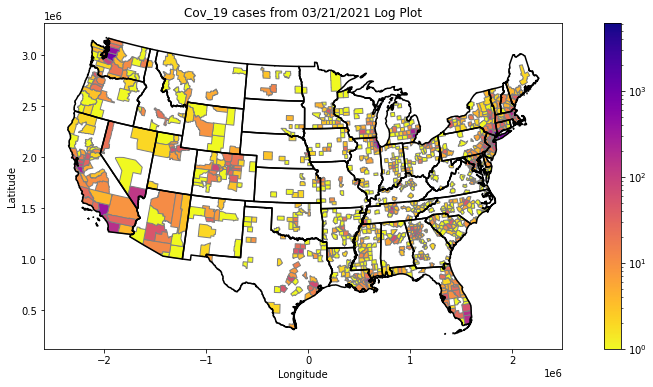

In [157]:
fig4,ax4 = plt.subplots(figsize=(15,6), ncols=1, nrows=1)
base = county_dissolve.boundary.plot(ax=ax4, color='black')
data = cov_state_date.cases
norm = LogNorm(vmin=min(data), vmax=max(data))

ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
ax4.set_title('Cov_19 cases from 03/21/2021 Log Plot')
cov_state_date.plot(column='cases', cmap='plasma_r', legend=True, edgecolor='gray', norm=norm, ax=base)

## Problem 5
In this problem, you will create an animation of the spread of Covid-19 through US counties from January 21, 2020 to June 21, 2020.
Use a log scale and a good colormap, and be sure that you're using the same norm and colorbar for the whole animation.
Use EPSG:5071 for the CRS.

As a reminder, below is a summary of what you will need in order to animate this map.
You may also find it helpful to refer to the animation section included with the Volume 4 lab manual. 

- Set up your figure and norm. Be sure to use the highest case count for your vmax so that the scale remains uniform.
- Write your update function. This should plot the cases from a given day.
- Set up your colorbar. Do this outside the update function to avoid adding a new colorbar each day.
- Create the animation. Check to make sure everything displays properly before you save it.
- Save the animation.
- Display the animation.

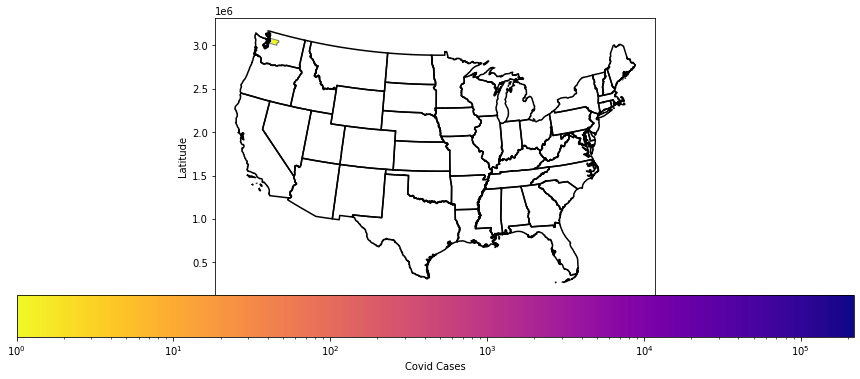

In [166]:
#Set up figure and norm
fig5,ax5 = plt.subplots(figsize=(15,6), ncols=1, nrows=1)
base = county_dissolve.boundary.plot(ax=ax5, color='black')
data = cov_merge.cases
norm = LogNorm(vmin=min(data), vmax=max(data))
date_range = sorted(set(cov_merge['date']))

def update(date):
    #Plot the cases from a single day
    this_day = cov_merge[cov_merge['date']==date].copy()
    this_day.plot(column='cases', cmap='plasma_r', edgecolor='gray', norm=norm, ax=base)
    ax5.set_xlabel('Longitude')
    ax5.set_ylabel('Latitude')
    ax5.set_title('Daily Covid_19 Cases starting January 21, 2020')
    
#Set up the colorbar
cbar = fig5.colorbar(ScalarMappable(norm=norm, cmap='plasma_r'), ax=ax5, orientation='horizontal', pad=0, label='Covid Cases')
#Create the animation
ani = animation.FuncAnimation(fig5, update, frames=date_range, interval=25)

In [167]:
#Save the animation
HTML(ani.to_html5_video())

<Figure size 432x288 with 0 Axes>

In [ ]:
ani.save('covid_ani.mp4')

<video src='your_video_name.mp4' controls width=800>